In [1]:
from numpy import linspace, zeros, meshgrid, flip
from matplotlib.pyplot import subplots, colorbar
from matplotlib.cm import get_cmap
from weichsel_schwarz import Network
from dill import dump_session, load_session
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
load_session('2020-04-27-kb-60-kc-vs-num-front-ends.db')

In [2]:
num_intervals = 20
capping_rate_const_row = linspace(0.01, 1.0, num_intervals)
num_front_filaments_row = linspace(1, 100, num_intervals, dtype=int)
num_replicates = 10
order_parameter_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))
rel_growth_rate_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))
nucleation_rate_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))
density_active_mat = zeros((num_front_filaments_row.size, capping_rate_const_row.size, num_replicates))

In [3]:
from joblib import Parallel, delayed
def compute_network_properties(x, y):
    network = Network(num_front_filaments=x, capping_rate_const=y)
    network.branching_rate_const = 60.0
    network.simulate()
    network.compute_order_parameter()
    rel_growth_rate = network.leading_edge_position / network.current_time / network.elongation_rate_const
    nucleation_rate = (network.barbed_position_mat.shape[0] - 150) / network.current_time
    density_active = network.active_filament_index.size
    return network.order_parameter, rel_growth_rate, nucleation_rate, density_active

In [4]:
for k in range(num_replicates):
    for i in range(num_intervals):
        ijk_output = Parallel(n_jobs=-1)(delayed(compute_network_properties)(num_front_filaments_row[i], capping_rate_const_row[j]) for j in range(num_intervals))
        for j in range(num_intervals):
            order_parameter_mat[i, j, k] = ijk_output[j][0]
            rel_growth_rate_mat[i, j, k] = ijk_output[j][1]
            nucleation_rate_mat[i, j, k] = ijk_output[j][2]
            density_active_mat[i, j, k] = ijk_output[j][3]

In [21]:
ticks_row = linspace(1, num_intervals - 1, 5, dtype=int)
x_label_row = []
y_label_row = []
for i in ticks_row:
    x_label_row.append('{:.2f}'.format(capping_rate_const_row[i]))
    y_label_row.append('{:n}'.format(num_front_filaments_row[-i]))

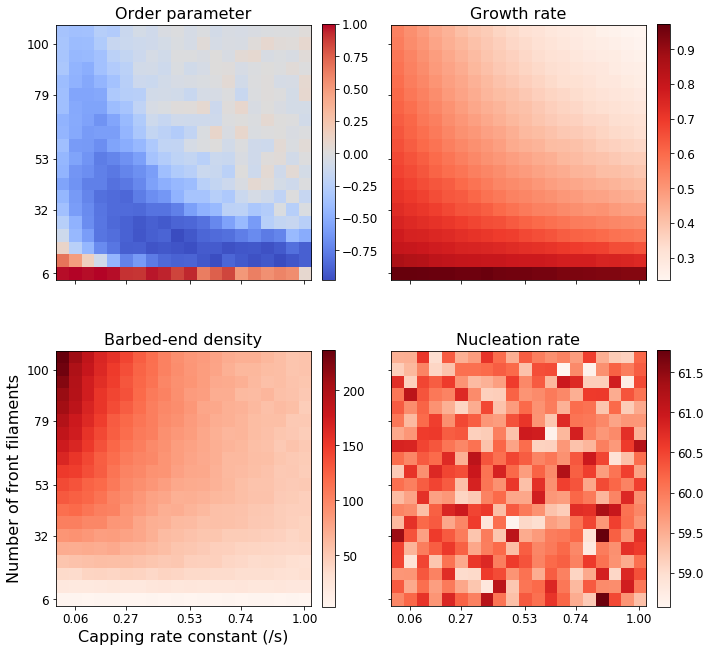

In [26]:
fig5_hand, axes5_hand = subplots(2, 2, sharey=True, sharex=True)
fig5_hand.set_figwidth(11)
fig5_hand.set_figheight(11)
im5a_hand = axes5_hand[0][0].imshow(flip(order_parameter_mat, 0).mean(axis=-1), cmap=get_cmap('coolwarm'))
axes5_hand[0][0].set_title('Order parameter', fontsize=16)
im5b_hand = axes5_hand[0][1].imshow(flip(rel_growth_rate_mat, 0).mean(axis=-1), cmap=get_cmap('Reds'))
axes5_hand[0][1].set_title('Growth rate', fontsize=16)
im5c_hand = axes5_hand[1][0].imshow(flip(density_active_mat, 0).mean(axis=-1), cmap=get_cmap('Reds'))
axes5_hand[1][0].set_title('Barbed-end density', fontsize=16)
im5d_hand = axes5_hand[1][1].imshow(flip(nucleation_rate_mat, 0).mean(axis=-1), cmap=get_cmap('Reds'))
axes5_hand[1][1].set_title('Nucleation rate', fontsize=16)
for i in range(2):
    for j in range(2):
        axes5_hand[i][j].set_xticks(ticks_row)
        axes5_hand[i][j].set_xticklabels(x_label_row, fontsize=12)
        axes5_hand[i][j].set_yticks(ticks_row)
        axes5_hand[i][j].set_yticklabels(y_label_row, fontsize=12)
bar5a_hand = fig5_hand.colorbar(im5a_hand, ax=axes5_hand[0][0], fraction=0.046, pad=0.04)
bar5a_hand.ax.tick_params(labelsize=12)
bar5b_hand = fig5_hand.colorbar(im5b_hand, ax=axes5_hand[0][1], fraction=0.046, pad=0.04)
bar5b_hand.ax.tick_params(labelsize=12)
bar5c_hand = fig5_hand.colorbar(im5c_hand, ax=axes5_hand[1][0], fraction=0.046, pad=0.04)
bar5c_hand.ax.tick_params(labelsize=12)
axes5_hand[1][0].set_xlabel('Capping rate constant (/s)', fontsize=16)
axes5_hand[1][0].set_ylabel('Number of front filaments', fontsize=16)
bar5d_hand = fig5_hand.colorbar(im5d_hand, ax=axes5_hand[1][1], fraction=0.046, pad=0.04)
bar5d_hand.ax.tick_params(labelsize=12)
fig5_hand.savefig('capping-rate-const-vs-num-front-filaments-phase-diagrams.png')

In [23]:
dump_session('2020-04-27-kb-60-kc-vs-num-front-ends.db')